In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM

# load model and dataset
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained('thuml/sundial-base-128m', trust_remote_code=True).to(device)

/Users/sriva/miniconda3/envs/ctf-sundial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sriva/miniconda3/envs/ctf-sundial/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/sriva/miniconda3/envs/ctf-sundial/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Lorenz System

In [2]:
import numpy as np
from scipy.integrate import ode

def lorenz(sigma, rho, beta, tau=1.):
    f = lambda t,x : [sigma*(x[1] - x[0])/tau, (x[0]*(rho - x[2]) - x[1])/tau, (x[0]*x[1] - beta*x[2])/tau]
    jac = lambda t,x : [[-sigma/tau, sigma/tau, 0.],
                        [(rho - x[2])/tau, -1./tau, -x[0]/tau],
                        [x[1]/tau, x[0]/tau, -beta/tau]]
    return f,jac


def simulate_lorenz(dt, n_timesteps, x0=None, sigma=10., rho=28., beta=8/3, tau=1.):
    if x0 is None:
        x0 = [-8, 7, 27]

    f,jac = lorenz(sigma, rho, beta, tau=tau)
    r = ode(f,jac).set_integrator('zvode', method='bdf')
    r.set_initial_value(x0, 0.0)

    x = [x0]
    t = [0.0]
    xprime = [f(0.0,x0)]
    while r.successful() and len(x) < n_timesteps:
        r.integrate(r.t + dt)
        x.append(np.real(r.y))
        xprime.append(f(r.t,np.real(r.y)))
        t.append(r.t)

    return np.array(x).T, np.array(t), np.array(xprime).T


lorenz_data, times = simulate_lorenz(dt=0.01, n_timesteps=10000)[:2]

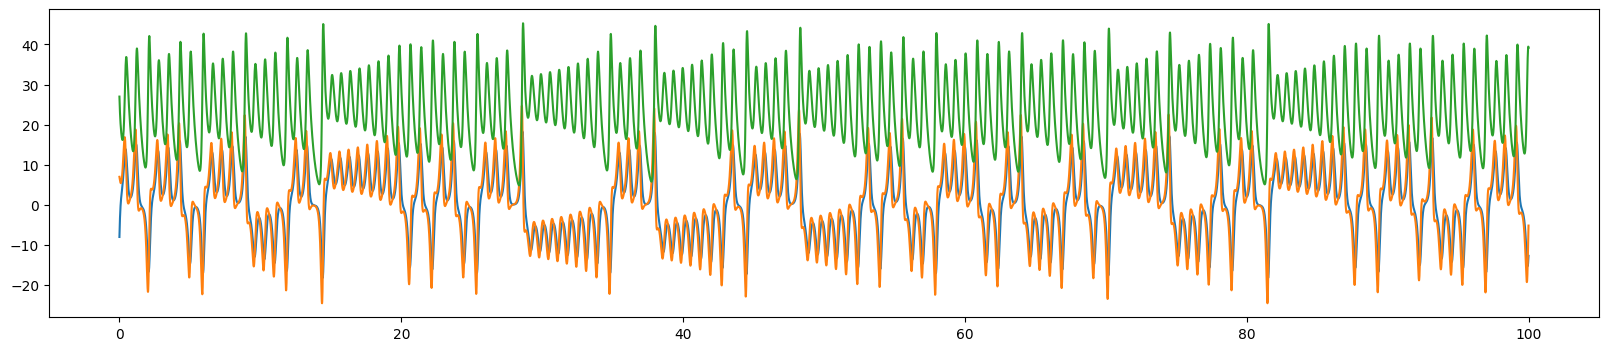

In [3]:
fig, axs = plt.subplots(figsize=(20,4))

plt.plot(times, lorenz_data.T)

In [4]:
# perpare input

lookback_length = 5000
lookback = torch.tensor(lorenz_data[:, :lookback_length] + np.random.normal(scale=1, size=lorenz_data[:, :lookback_length].shape),
                        dtype=torch.float32).to(device)
lookback.shape

torch.Size([3, 5000])

In [5]:
# forecasting configurations

forecast_length = len(times) - lookback_length
num_samples = 10
forecast = model.generate(lookback, max_new_tokens=forecast_length, num_samples=num_samples)

In [6]:
lookback = lookback.cpu()

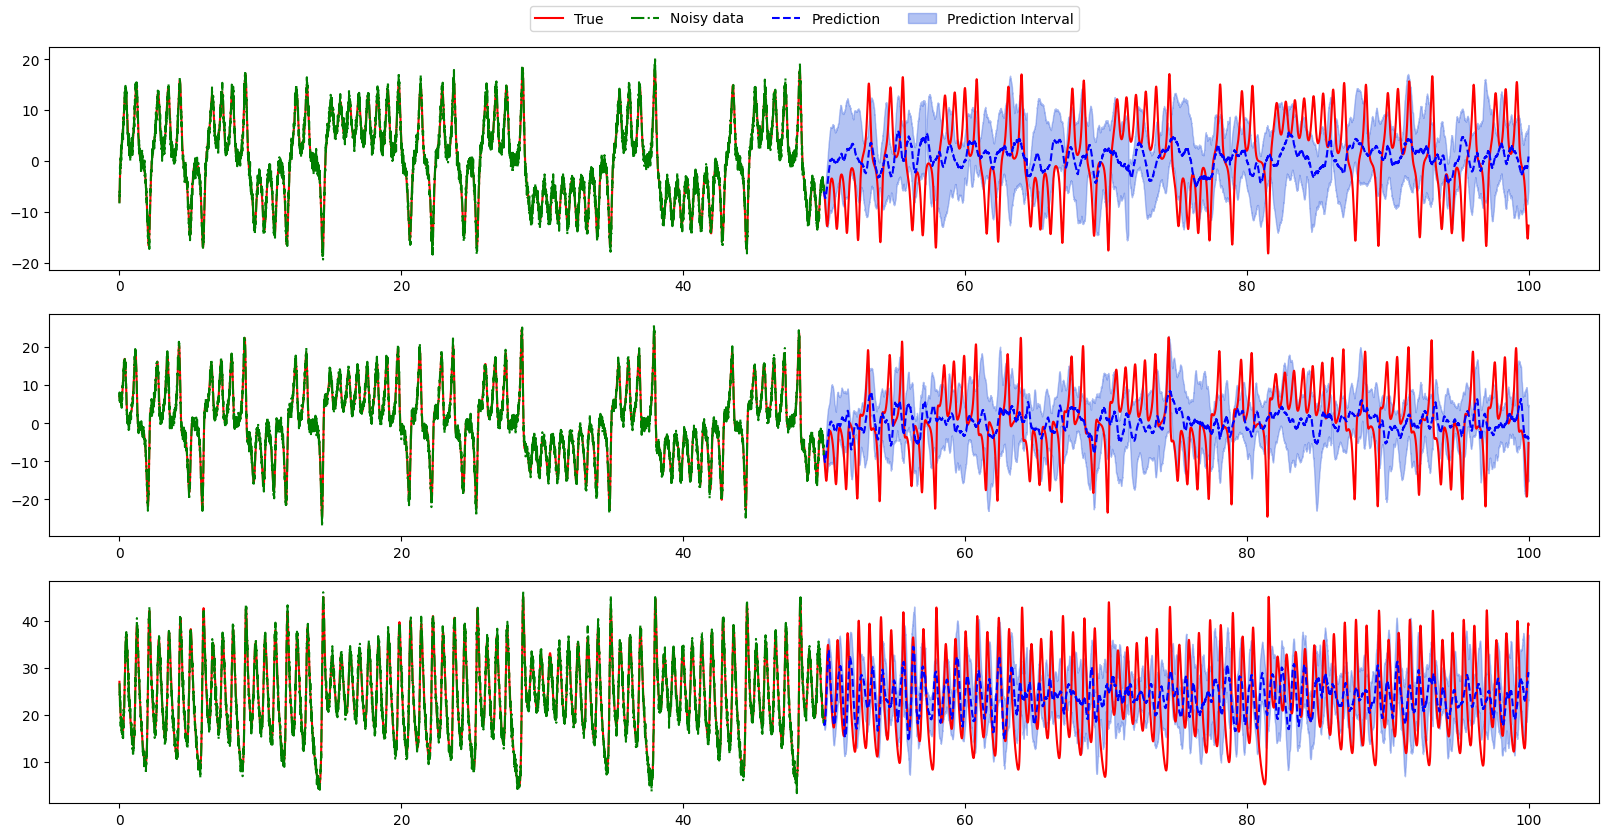

In [7]:
fig, axs = plt.subplots(forecast.shape[0], 1, figsize=(20, 3 * forecast.shape[0]))

for ii in range(axs.shape[0]):
    axs[ii].plot(times, lorenz_data[ii], 'r', label='True')
    axs[ii].plot(times[:lookback_length], lookback[ii], 'g-.', label='Noisy data')
    axs[ii].plot(times[lookback_length:], forecast[ii].cpu().numpy().mean(axis=0), 'b--', label='Prediction')
    axs[ii].fill_between(times[lookback_length:], forecast[ii].cpu().quantile(q=0.05, dim=0), forecast[ii].cpu().quantile(q=0.95, dim=0), alpha=0.4, color="royalblue", label='Prediction Interval')

_line, _label = axs[0].get_legend_handles_labels()
fig.legend(_line, _label, loc='upper center', ncols=4)

fig.subplots_adjust(top=0.95)

## KS

In [8]:
# DEFINE THE STATE PROBLEM SOLVER
import sys
from tqdm import tqdm

def compute_state(nu, omega, dt, T, nstepsoutput = 300):
    """
    Compute the state trajectory
    Input: viscosity, initial condition frequency, time step, final time and number of steps to return
    Output: time-dependent state
    Credits: https://github.com/E-Renshaw/kuramoto-sivashinsky
    """

    u0 = lambda x: np.cos(omega * 2 * np.pi * x / L) * (1 + np.sin(omega * 2 * np.pi * x / L)) # initial condition

    v = np.fft.fft(u0(x))

    # Scalars for the Exponential Time Differencing fourth-order Runge-Kutta (ETDRK4)
    domain_length = x[-1] - x[0]
    k = 2 * np.pi / domain_length * np.transpose(np.conj(np.concatenate((np.arange(0, nstate/2), np.array([0]), np.arange(-nstate/2+1, 0)))))
    l = k**2 - nu * k**4
    E = np.exp(dt*l)
    E2 = np.exp(dt*l/2)

    M = 16
    r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
    LR = dt*np.transpose(np.repeat([l], M, axis=0)) + np.repeat([r], nstate, axis=0)
    Q  = dt*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = dt*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = dt*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = dt*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

    u = np.array([u0(x)])
    ntimesteps = round(T / dt)
    freqoutput = round((T / nstepsoutput) / dt)
    g = -0.5j*k

    for i in tqdm(range(1, ntimesteps + 1), colour = "cyan", file = sys.stdout, bar_format = 'Computing state |{bar}| {n}/{total} {elapsed}<{remaining}'):
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
        a = E2*v + Q*Nv
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
        b = E2*v + Q*Na
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
        c = E2*a + Q*(2*Nb-Nv)
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        if i % freqoutput == 0:
            un = np.real(np.fft.ifft(v))
            u = np.append(u, np.array([un]), axis=0)

    return u


nstate = 100
L = 6 * np.pi
x = np.linspace(0, L, nstate)

# SOLVE THE STATE PROBLEM

dt = 1e-2
T = 50
nstepsoutput = 5000

nu = 0.2
omega = 2.0

ut = compute_state(nu, omega, dt, T, nstepsoutput)[:-1]
times = np.arange(0, nstepsoutput) * T/nstepsoutput

Computing state |██████████| 5000/5000 00:00<00:00


Text(0, 0.5, 'x')

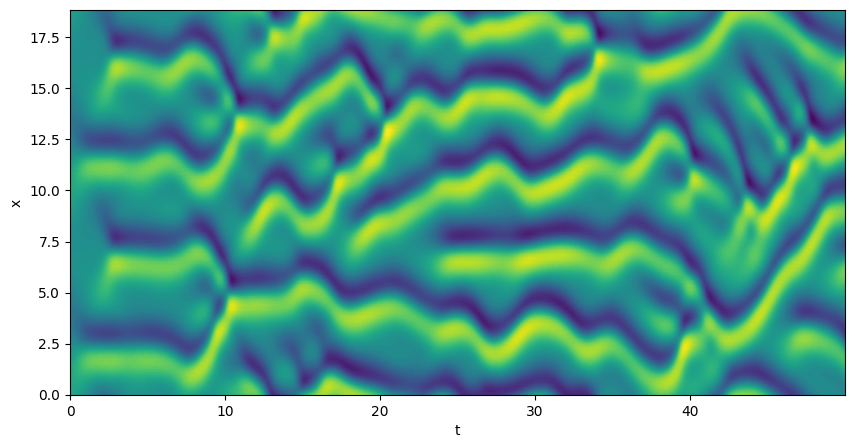

In [9]:
fig, axs = plt.subplots(figsize=(10,5))

xgrid, tgrid = np.meshgrid(x, times)

axs.contourf(tgrid, xgrid, ut, cmap='viridis', levels=100)
axs.set_xlabel('t')
axs.set_ylabel('x')

In [10]:
# perpare input

noisy_data = ut + np.random.normal(scale=0.2, size=ut.shape)

lookback_length = 2500
lookback = torch.tensor(noisy_data.T[:, :lookback_length],
                        dtype=torch.float32).to(device)
lookback.shape

torch.Size([100, 2500])

In [11]:
# forecasting configurations

forecast_length = ut.shape[0] - lookback_length
print(forecast_length)
num_samples = 50
forecast = model.generate(lookback, max_new_tokens=forecast_length, num_samples=num_samples)

2500


In [12]:
forecast = forecast.cpu()
forecast.shape

torch.Size([100, 50, 2500])

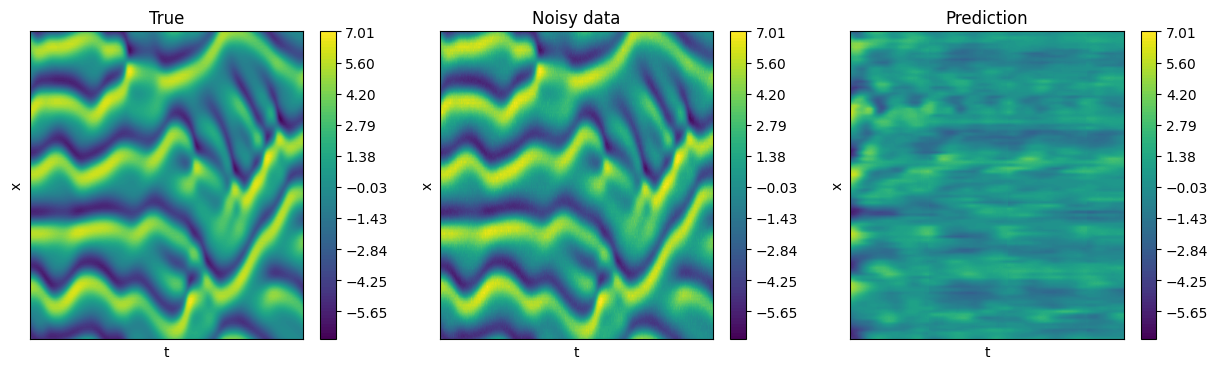

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

xgrid, tgrid = np.meshgrid(x, times[lookback_length:])

levels = np.linspace(ut.min(), ut.max(), 100)

cont = axs[0].contourf(tgrid, xgrid, ut[lookback_length:], cmap='viridis', levels=levels)
axs[1].contourf(tgrid, xgrid, noisy_data[lookback_length:], cmap='viridis', levels=levels)
axs[2].contourf(tgrid, xgrid, forecast.cpu().numpy().mean(axis=1).T, cmap='viridis', levels=levels)

axs[0].set_title('True')
axs[1].set_title('Noisy data')
axs[2].set_title('Prediction')

for ax in axs:
    fig.colorbar(cont, ax=ax, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('t')
    ax.set_ylabel('x')

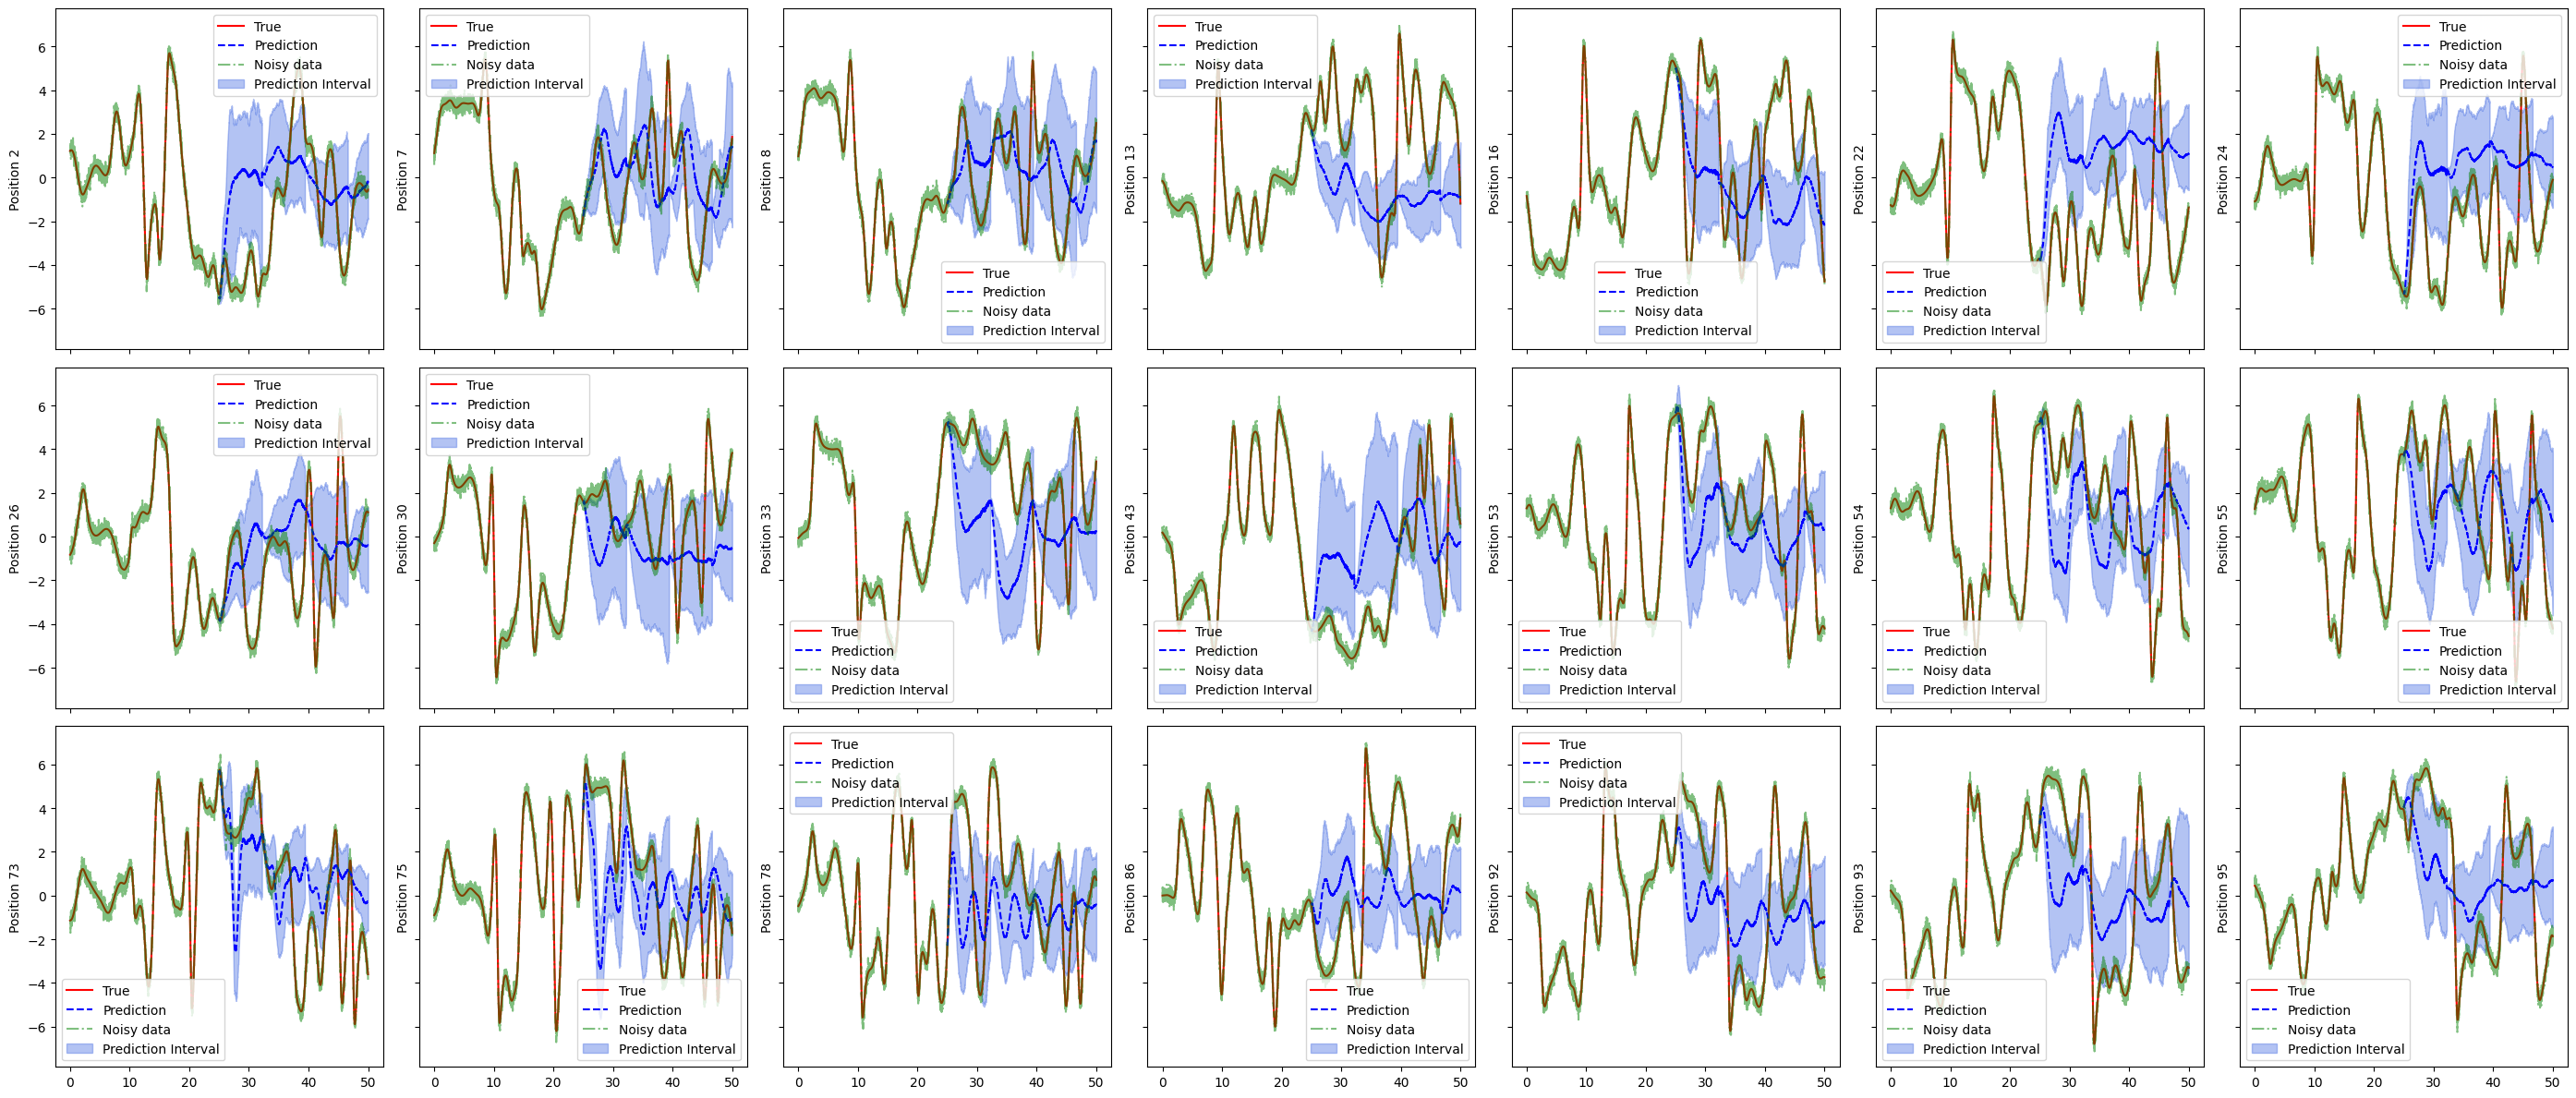

In [14]:
nrows = 3
ncols = 7

fig, axs = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()

np.random.seed(0)
locs = np.sort(np.random.choice(np.arange(ut.shape[1]), size=nrows * ncols, replace=False))

for rr in range(len(axs)):
  axs[rr].plot(times, ut[:, locs[rr]], 'r', label='True')
  axs[rr].plot(times[lookback_length:], forecast[locs[rr]].cpu().numpy().mean(axis=0), 'b--', label='Prediction')
  axs[rr].plot(times, noisy_data[:, locs[rr]], 'g-.', label='Noisy data', alpha=0.5)
  axs[rr].fill_between(times[lookback_length:],
                       forecast[locs[rr]].cpu().quantile(q=0.05, dim=0), forecast[locs[rr]].cpu().quantile(q=0.95, dim=0), alpha=0.4, color="royalblue", label='Prediction Interval')

  axs[rr].set_ylabel(f'Position {locs[rr]}')
  axs[rr].legend()

plt.tight_layout()